# Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

tf.enable_eager_execution()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']

print('append path prefix')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# subtract label id by 1
dataset_index['label'] -= 1

print('subtract label id by 1')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# train-test split
train_index = dataset_index.sample(frac=0.7) # 70% train
train_size = train_index.shape[0]
test_index = dataset_index.drop(train_index.index)
val_index = test_index.sample(frac=0.5) # 15% val
val_size = val_index.shape[0]
test_index = test_index.drop(val_index.index) # 15% test
test_size = test_index.shape[0]

print('Train')
print(train_index.shape)
print(train_index.head())
print('\n')
print('Val')
print(val_index.shape)
print(val_index.head())
print('\n')
print('Test')
print(test_index.shape)
print(test_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east


append path prefix
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg


subtract label id by 1
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     37  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     25  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      8        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     35  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5

## Create datasets, preprocessing

Instructions for updating:
Colocations handled automatically by placer.
train size 1760
val size 376
test size 380


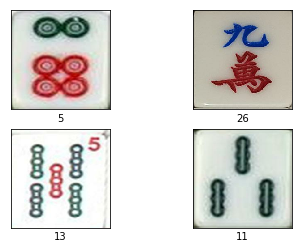

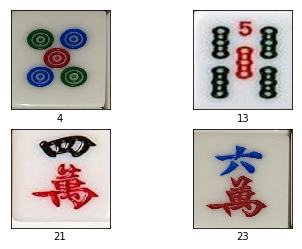

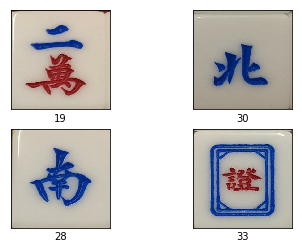

In [3]:
def show_image_sample(ds):
    for n, (image, label) in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(np.argmax(label))
    plt.show()

def read_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

def rotate_image(image, label):
    image = tf.image.rot90(image)
    return image, label

def get_dataset(dataset_index):
    path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    
    label_one_hot = tf.one_hot(dataset_index['label'], num_classes)
    label_ds = tf.data.Dataset.from_tensor_slices(label_one_hot)
    
    paired_ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    paired_ds_90 = paired_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds_180 = paired_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds_270 = paired_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
    paired_ds = paired_ds.concatenate(paired_ds_90).concatenate(paired_ds_180).concatenate(paired_ds_270)

    return paired_ds
    
train_ds = get_dataset(train_index)
train_size *= 4
print('train size', train_size)

val_ds = get_dataset(val_index)
val_size *= 4
print('val size', val_size)

test_ds = get_dataset(test_index)
test_size *= 4
print('test size', test_size)

show_image_sample(train_ds)
show_image_sample(val_ds)
show_image_sample(test_ds)

## Load encoder model

In [4]:
encoder = keras.models.load_model('./models/encoder_final.h5')
for layer in encoder.layers:
    layer.trainable = False
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 318, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 157, 157, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 16)        2064      
__________

## Define FC model

In [5]:
fc = keras.Sequential(layers=[
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), input_shape=(16,16,16)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.AlphaDropout(rate=0.3),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.AlphaDropout(rate=0.3),
    keras.layers.Dense(num_classes, activation='softmax')
], name='fc')
print(fc.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 512)               0         
___________________________

## Train classifier model

In [6]:
batch_size = 32
lr = 7e-4
b1 = 0.9
b2 = 0.99
# TODO: run again
config_str = str(batch_size)+'_adam_'+str(lr)+'_'+str(b1)+'_'+str(b2)+'20190514'

train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier_input = keras.Input(shape=(320,320,3))
classifier_output = fc(encoder(classifier_input))
classifier = keras.Model(inputs=classifier_input, outputs=classifier_output)

optim = keras.optimizers.Adam(lr=lr, beta_1=b1, beta_2=b2)
classifier.compile(optimizer=optim,
                   loss='categorical_crossentropy',
                   metrics=['categorical_accuracy'])
print(classifier.summary())

classifier.fit(train_ds_batch,
               epochs=50,
               steps_per_epoch=int(train_size/batch_size),
               validation_data=val_ds_batch,
               validation_steps=int(val_size/batch_size),
               callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/classifier/'+config_str),
                         keras.callbacks.ModelCheckpoint('./models/classifier_best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)]
            )

# load best weights during training
classifier.load_weights('./models/classifier_best_weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
encoder (Sequential)         (None, 16, 16, 16)        18656     
_________________________________________________________________
fc (Sequential)              (None, 42)                809066    
Total params: 827,722
Trainable params: 809,034
Non-trainable params: 18,688
_________________________________________________________________
None
Epoch 1/50
Instructions for updating:
Use tf.cast instead.
55/55 [==============================] - 11s 201ms/step - loss: 3.6988 - categorical_accuracy: 0.1386 - val_loss: 13.8158 - val_categorical_accuracy: 0.0312
Epoch 2/50
55/55 [==============================] - 5s 85ms/step - loss: 2.4267 - categorical_accuracy: 0.3278 - val_loss: 11.1862 - val_categorical_accuracy: 0.0312
Epoch 3/

## Test Classifier Model

In [7]:
test_ds_batch = test_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=test_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier.evaluate(test_ds_batch, steps=int(test_size/batch_size))

11/11 [==============================] - 1s 112ms/step - loss: 2.9060 - categorical_accuracy: 0.5795


[2.9060484062541616, 0.57954544]

## Visualize Predictions

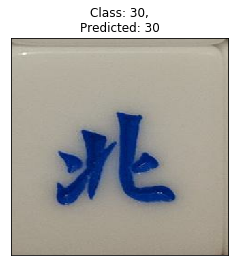

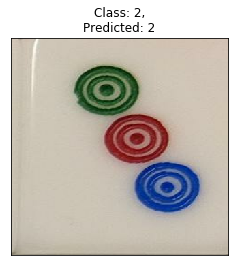

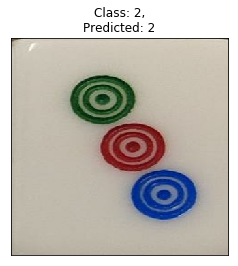

In [8]:
for n, (image, label) in enumerate(test_ds.take(3)):
    pred = classifier.predict_on_batch(x=image[np.newaxis,:])[0]
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title("Class: {},\nPredicted: {}".format(np.argmax(label), np.argmax(pred)))
    plt.show()

## Predict per class

In [9]:
batch_size = 1

test_ds_batch = test_ds.cache().batch(1).prefetch(buffer_size=AUTOTUNE)

y_pred = classifier.predict(test_ds_batch, verbose=1, steps=test_size)
y_pred_label = np.argmax(y_pred, axis=1)

y_test = test_index['label'].tolist()
for i in range(2):
    y_test.extend(y_test)

print(classification_report(y_test, y_pred_label))

380/380 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         8
           3       1.00      0.62      0.77         8
           4       0.80      1.00      0.89         4
           5       0.60      0.50      0.55        12
           6       0.84      0.67      0.74        24
           7       0.86      0.75      0.80        16
           8       0.73      1.00      0.84         8
           9       0.00      0.00      0.00        12
          10       1.00      0.75      0.86         4
          11       1.00      0.75      0.86        16
          12       0.73      1.00      0.84         8
          14       0.73      0.67      0.70        12
          15       0.67      1.00      0.80         8
          16       0.83      1.00      0.91        20
          17       0.75   

C:\Users\Esmond\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Esmond\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Top k class accuracy

In [10]:
top_k = keras.backend.in_top_k(y_pred, y_test, 5)
top_k_acc = np.sum(top_k) / test_size
print("Top 5 accuracy: {}".format(top_k_acc))

Top 5 accuracy: 0.8052631578947368


## Save model

In [9]:
fc.save('./models/fc_final.h5')

## Generate model diagram

In [7]:
import pydot
import graphviz
keras.utils.plot_model(
    fc,
    to_file='fc.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)